<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10240 entries, 0 to 10239
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 10240 non-null  object
 1   label              10240 non-null  object
 2   statement          10240 non-null  object
 3   subjects           10240 non-null  object
 4   speaker            10240 non-null  object
 5   speaker_job_title  10240 non-null  object
 6   state_info         10240 non-null  object
 7   party_affiliation  10240 non-null  object
 8   barelyTrueCount    10240 non-null  object
 9   falseCount         10240 non-null  object
 10  halfTruecCount     10240 non-null  object
 11  mostlyTrueCount    10240 non-null  object
 12  pantsOnFireCount   10240 non-null  object
 13  context            10240 non-null  object
dtypes: object(14)
memory usage: 1.1+ MB
              precision    recall  f1-score   support

           0       0.56      0.48      0.52



LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Fake News 
SVM Prediction: Real News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Fake News 
SVM Prediction: Fake News


LR Prediction: Fake News 
SVM Prediction: Fake News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Fake News 
SVM Prediction: Fake News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Fake News 
SVM Prediction: Fake News


LR Prediction: Fake News 
SVM Prediction: Fake News


LR Prediction: Fake News 
SVM Prediction: Fake News


LR Prediction: Fake News 
SVM Prediction: Fake News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Fake News 
SVM Prediction: Fake News


LR Prediction: Real News 




LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Fake News 
SVM Prediction: Fake News


LR Prediction: Fake News 
SVM Prediction: Fake News


LR Prediction: Fake News 
SVM Prediction: Fake News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Fake News 
SVM Prediction: Fake News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Fake News 
SVM Prediction: Fake News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Fake News 
SVM Prediction: Fake News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Fake News 
SVM Prediction: Fake News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Real News 




LR Prediction: Fake News 
SVM Prediction: Real News


LR Prediction: Fake News 
SVM Prediction: Fake News


LR Prediction: Real News 
SVM Prediction: Fake News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Fake News 
SVM Prediction: Fake News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Fake News 
SVM Prediction: Fake News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Fake News 
SVM Prediction: Fake News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Real News 




LR Prediction: Fake News 
SVM Prediction: Fake News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Fake News 
SVM Prediction: Fake News


LR Prediction: Fake News 
SVM Prediction: Fake News


LR Prediction: Fake News 
SVM Prediction: Fake News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Fake News 
SVM Prediction: Fake News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Fake News 
SVM Prediction: Fake News


LR Prediction: Fake News 
SVM Prediction: Fake News


LR Prediction: Fake News 
SVM Prediction: Fake News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Real News 




LR Prediction: Fake News 
SVM Prediction: Real News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Fake News 
SVM Prediction: Real News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Fake News 
SVM Prediction: Fake News


LR Prediction: Fake News 
SVM Prediction: Fake News


LR Prediction: Fake News 
SVM Prediction: Fake News


LR Prediction: Fake News 
SVM Prediction: Real News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Fake News 
SVM Prediction: Fake News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Fake News 
SVM Prediction: Fake News


LR Prediction: Fake News 
SVM Prediction: Fake News


LR Prediction: Fake News 
SVM Prediction: Real News


LR Prediction: Real News 




LR Prediction: Fake News 
SVM Prediction: Fake News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Fake News 
SVM Prediction: Fake News


LR Prediction: Fake News 
SVM Prediction: Fake News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Fake News 
SVM Prediction: Fake News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Fake News 
SVM Prediction: Fake News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Fake News 
SVM Prediction: Fake News


LR Prediction: Fake News 




LR Prediction: Fake News 
SVM Prediction: Fake News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Fake News 
SVM Prediction: Fake News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Fake News 
SVM Prediction: Fake News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Fake News 
SVM Prediction: Fake News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Fake News 
SVM Prediction: Fake News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Real News 




LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Fake News 
SVM Prediction: Fake News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Fake News 
SVM Prediction: Fake News


LR Prediction: Fake News 
SVM Prediction: Fake News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Fake News 
SVM Prediction: Fake News


LR Prediction: Fake News 
SVM Prediction: Fake News


LR Prediction: Fake News 
SVM Prediction: Fake News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Real News 
SVM Prediction: Real News


LR Prediction: Fake News 


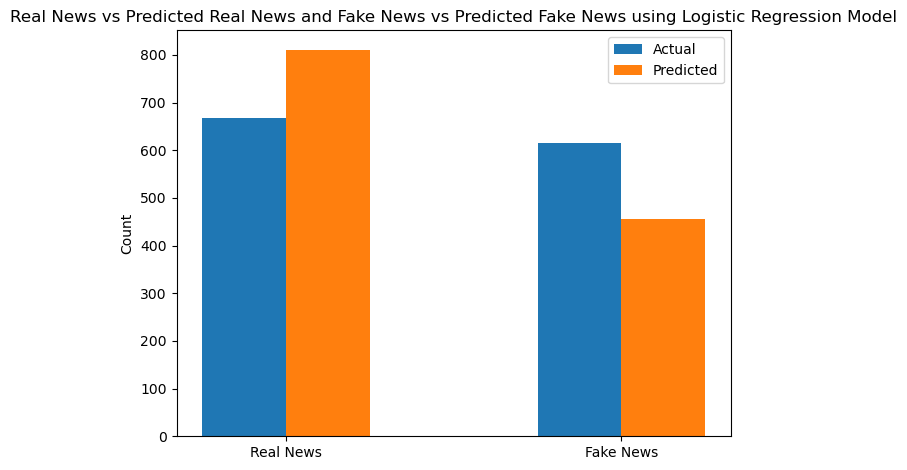

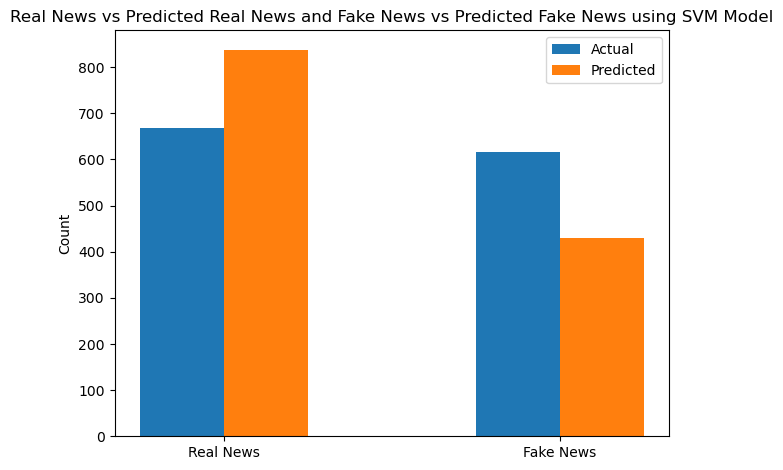

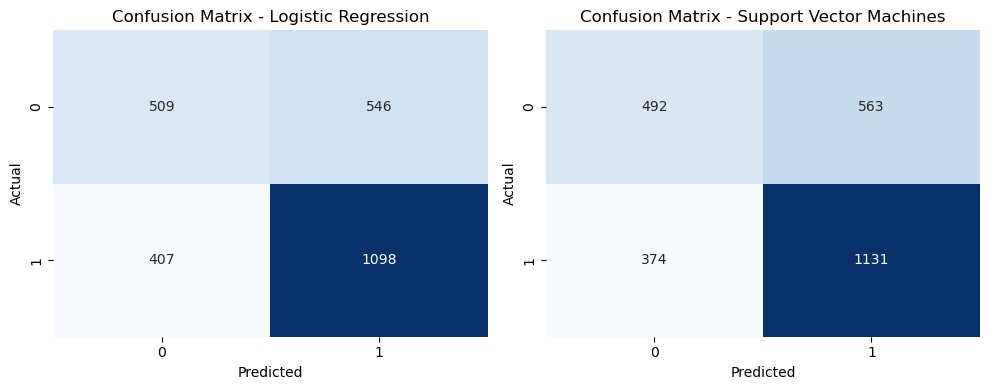

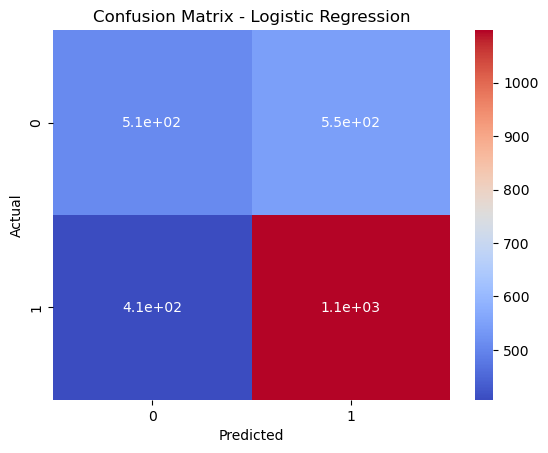

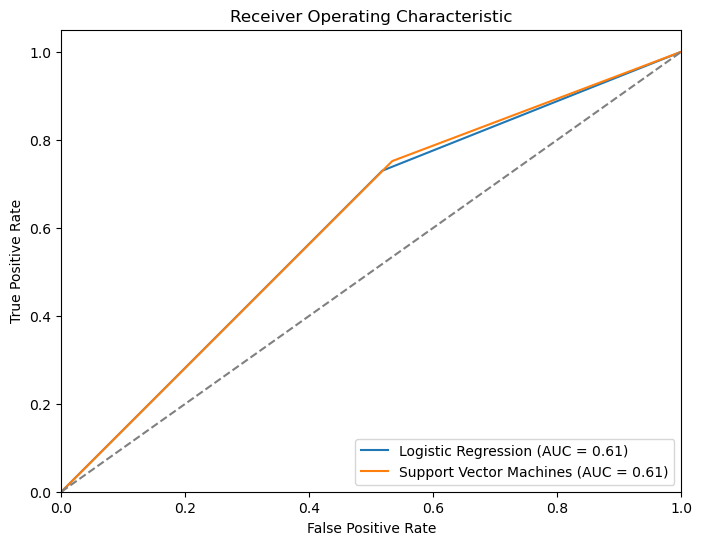

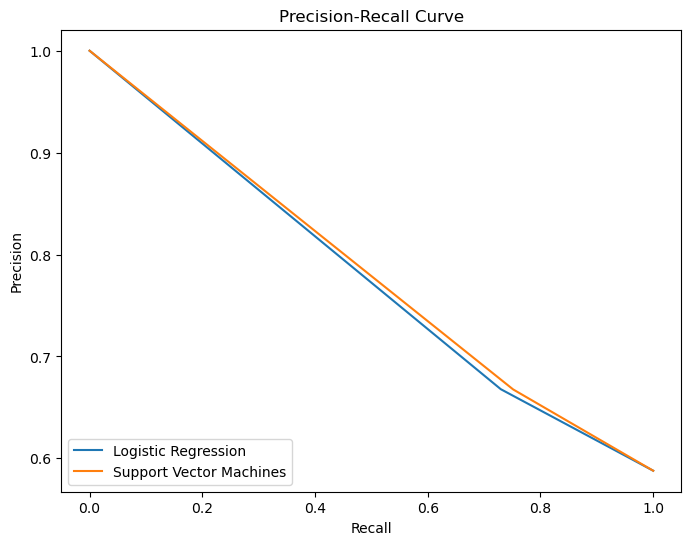

0.6973642426167037
0.7070959674898405
0.6678832116788321
0.6676505312868949
0.7295681063122924
0.7514950166112957
0.6060162806442979
0.6089228637558848
Number transactions X_train dataset:  (7680,)
Number transactions y_train dataset:  (7680,)
Number transactions X_test dataset:  (2560,)
Number transactions y_test dataset:  (2560,)
Before OverSampling, counts of label '1': 4247
Before OverSampling, counts of label '0': 3433 



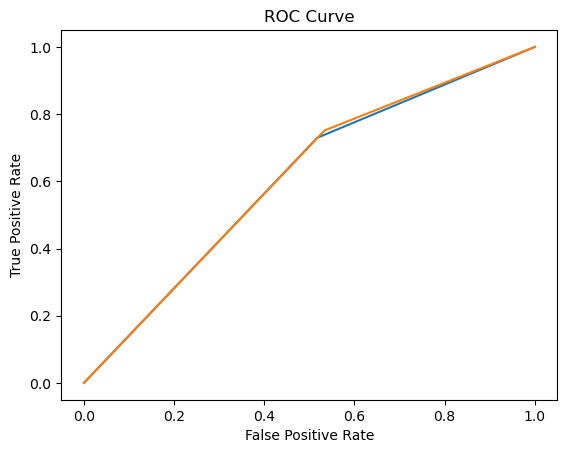

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

def read_dataframe(url) -> pd.DataFrame:
    liar_dataset_url = f"https://raw.githubusercontent.com/thiagorainmaker77/liar_dataset/master/{url}"
    data = pd.read_csv(liar_dataset_url, sep='\t', header=None)
    #data = pd.read_csv(tsv_file, delimiter='\t', dtype=object)
    data.fillna("", inplace=True)
    data.columns = [
        'id',                # Column 1: the ID of the statement ([ID].json).
        'label',            
        'statement',         
        'subjects',          
        'speaker',           
        'speaker_job_title', 
        'state_info',        
        'party_affiliation', 
        'barelyTrueCount', 
        'falseCount', 
        'halfTruecCount', 
        'mostlyTrueCount',
        'pantsOnFireCount', 
        'context' # the context (venue / location of the speech or statement).
    ]
    return data

data= read_dataframe("train.tsv")
data.info()

def TF(value):
    if value == 'pants-fire':
        return 0
    elif value == 'false':
        return 0
    elif value == 'barely-true':
        return 0
    elif value == 'half-true':
        return 1
    elif value == 'mostly-true':
        return 1
    else:
        return 1

data['T/F'] = data['label'].apply(TF)

x = data['statement']
y = data['T/F']

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size= 0.25)

vectorization = TfidfVectorizer()
xv_train = vectorization.fit_transform(x_train)
xv_test = vectorization.transform(x_test)

LR = LogisticRegression()
LR.fit(xv_train, y_train)
pred_lr = LR.predict(xv_test)
LR.score(xv_test, y_test)
print(classification_report(y_test, pred_lr))


SVM = SVC()
SVM.fit(xv_train, y_train)
pred_svm = SVM.predict(xv_test)
SVM.score(xv_test, y_test)
print(classification_report(y_test, pred_svm))

def clean(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W", " ", text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '',text)
    return text

def labels(outcome):
    if outcome == 0:
        return "Fake News"
    elif outcome == 1:
        return "Real News"

def testing(news):
    expriment_news = {"text":[news]}
    new_def_test = pd.DataFrame(expriment_news)
    new_def_test["text"] = new_def_test["text"].apply(clean)
    new_x_test = new_def_test["text"]
    new_xv_test = vectorization.transform(new_x_test)
    pred_LR = LR.predict(new_xv_test)
    pred_SVM = SVM.predict(new_xv_test)
    return pred_LR, pred_SVM
    

test_data= read_dataframe("test.tsv")
LR_array = []
SVM_array =[]

for x in test_data['statement']:
    pred_LR, pred_SVM = testing(x)
    LR_array.append(pred_LR)
    SVM_array.append(pred_SVM)
    print ("\n\nLR Prediction: {} \nSVM Prediction: {}".format(labels(pred_LR[0]), labels(pred_SVM[0])))

test_data['LR_Prediction'] = LR_array
test_data['SVM_Prediction'] = SVM_array


LR_real_pred=0
real =0
LR_fake_pred =0
fake = 0

for data in test_data['LR_Prediction']:
    if data == 1:
        LR_real_pred += 1
    if data == 0:
        LR_fake_pred += 1
                    
val_data= read_dataframe("valid.tsv")

val_data['T/F'] = val_data['label'].apply(TF)

for data in val_data['T/F']:
    if data == 1:
        real += 1
    if data == 0:
        fake += 1

categories = ['Real News', 'Fake News']
actual_values = [real, fake]
predicted_values = [LR_real_pred, LR_fake_pred]

x = np.arange(len(categories))
width = 0.25

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, actual_values, width, label='Actual')
rects2 = ax.bar(x + width/2, predicted_values, width, label='Predicted')

ax.set_ylabel('Count')
ax.set_title('Real News vs Predicted Real News and Fake News vs Predicted Fake News using Logistic Regression Model')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

fig.tight_layout()

plt.show()


SVM_real_pred=0
SVM_fake_pred =0

for data in test_data['SVM_Prediction']:
    if data == 1:
        SVM_real_pred += 1
    if data == 0:
        SVM_fake_pred += 1
                    

categories = ['Real News', 'Fake News']
actual_values = [real, fake]
predicted_values = [SVM_real_pred, SVM_fake_pred]

x = np.arange(len(categories))
width = 0.25

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, actual_values, width, label='Actual')
rects2 = ax.bar(x + width/2, predicted_values, width, label='Predicted')

ax.set_ylabel('Count')
ax.set_title('Real News vs Predicted Real News and Fake News vs Predicted Fake News using SVM Model')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

fig.tight_layout()

plt.show()


from sklearn.metrics import confusion_matrix

cm_lr = confusion_matrix(y_test, pred_lr)

cm_svm = confusion_matrix(y_test, pred_svm)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.heatmap(cm_lr, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.subplot(1, 2, 2)
sns.heatmap(cm_svm, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("Confusion Matrix - Support Vector Machines")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.tight_layout()
plt.show()


conf_matrix = pd.crosstab(y_test, pred_lr, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(conf_matrix, annot=True, cmap='coolwarm')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()



from sklearn.metrics import roc_curve, auc

fpr_lr, tpr_lr, _ = roc_curve(y_test, pred_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

fpr_svm, tpr_svm, _ = roc_curve(y_test, pred_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label="Logistic Regression (AUC = %0.2f)" % roc_auc_lr)
plt.plot(fpr_svm, tpr_svm, label="Support Vector Machines (AUC = %0.2f)" % roc_auc_svm)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()



from sklearn.metrics import precision_recall_curve

precision_lr, recall_lr, _ = precision_recall_curve(y_test, pred_lr)

precision_svm, recall_svm, _ = precision_recall_curve(y_test, pred_svm)

plt.figure(figsize=(8, 6))
plt.plot(recall_lr, precision_lr, label="Logistic Regression")
plt.plot(recall_svm, precision_svm, label="Support Vector Machines")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.show()


from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, KFold

from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectPercentile, chi2, f_regression, f_classif
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

roc_conf = confusion_matrix(y_test, pred_svm)

print(f1_score(y_test,pred_lr))
print(f1_score(y_test,pred_svm))

print(precision_score(y_test,pred_lr))
print(precision_score(y_test,pred_svm))

print(recall_score(y_test,pred_lr))
print(recall_score(y_test,pred_svm))

print(roc_auc_score(y_test,pred_lr))
print(roc_auc_score(y_test,pred_svm))

fpr, tpr, thresholds = roc_curve(y_test, pred_lr)

plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

fpr, tpr, thresholds = roc_curve(y_test, pred_svm)

plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

print("Number transactions X_train dataset: ", x_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", x_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))